# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [8]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 

#sns.set_style('whitegrid')
sns.set()

## 1. Is the distribution of body temperatures normal?

We can assume so, because of the following:
- <b>1.1 Data is roughly symmetric w/ few outliers.</b> Boxplot is roughly symmetric, with a few concerning outliers.
- <b>1.2 Sample population is not strongly skewed.</b> Theoretical CDF and ECDF visually align closely, as well as histogram of actual data and fitted normal distribution curve.
- <b>1.3 The null hypothesis that the distribution is normal <i>cannot</i> be rejected. </b> A statistical test of normality yields a p-value > 0.05 (0.26) - insufficient likelihood that the data distribution is non-normal.

### 1.1 Overview of data

A boxplot displays salient features of the data, based on percentiles. Specifically, the median (50th percentile) is displayed in the middle of box. The edges of the box represent the 25th and 75th percentiles of data. The box's height (IQR) contains the middle 50% of the data. Finally, whiskers extend 1.5 IQR's out. Anything outside the whiskers are taken to be outliers. A rule of thumb is outliers > 2 IQR's away is concerning.

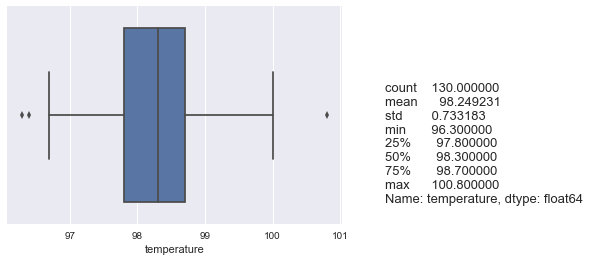

In [10]:
data = df['temperature']
sns.boxplot(data);
plt.figtext(1.0, 0.2, data.describe(), fontsize=13);

Although the bulk of data looks symmetric, the outliers in this dataset are a bit concerning, as they are > 2 IQR's away from the IQR. So we proceed w/ more tests.

### 1.2 Check ECDF & histogram for normality

Theoretical CDF and ECDF (empirical cumulative distribution function) suggest that the distribution of body temperatures is appx. normal, with possible right skew. Histogram of actual data align with normal distribution curve.

In [14]:
# Define ECDF function compute ECDF for a one-dim array of measurements

def ecdf(data):
    
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    
    return x, y

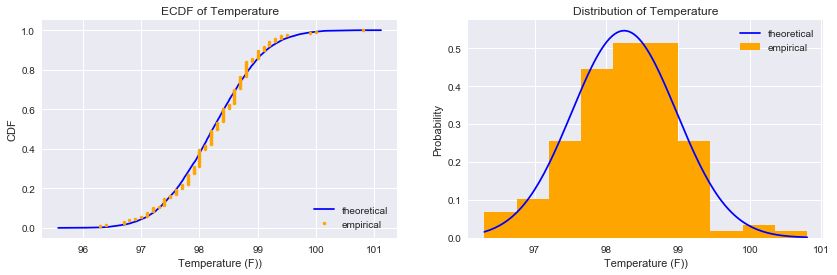

In [15]:
# Calculate population parameters
mu = data.mean()
sigma = data.std()

# Generate theoretical CDF
samples = np.random.normal(mu, sigma, size = 10000)
x_theor, y_theor = ecdf(samples)

# Generate theoretical normal distribution curve (PDF)
mu_theor, sigma_theor = stats.norm.fit(data)
lnspc = np.linspace(data.min(), data.max(), len(data))
pdf = stats.norm.pdf(lnspc, mu_theor, sigma_theor) 

# Organize empirical data
x, y = ecdf(data)

# Set subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,4))

# Fig 1: Theoretical & empirical CDF's
ax1.plot(x_theor, y_theor, color='blue') ;
ax1.plot(x, y, marker='.', linestyle='none', color='orange');
ax1.set(xlabel='Temperature (F))', ylabel='CDF', title='ECDF of Temperature')
ax1.legend(('theoretical', 'empirical'), loc='lower right');

# Fig 2: Histogram & theoretical normal distribution curve
ax2.hist(data, normed=True, color='orange');
ax2.plot(lnspc, pdf, label="Norm", color='blue') 
ax2.set(xlabel='Temperature (F))', ylabel='Probability', title='Distribution of Temperature')
ax2.legend(('theoretical', 'empirical'), loc='upper right');

### 1.3 A statistical test for normality: Scipy "normaltest"

Finally, to get more specific beyond eyeballing the data, we employ Scipy's [normaltest](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.mstats.normaltest.html). 

<i>Basis</i>: This test is based on D’Agostino and Pearson’s (1973) test of normality, which combines skew and kurtosis measurements to determine how far the actual distribution deviates from its expected values under a Gaussian distribution. The sum of these discrepencies is used to calculate a single P-value. It is designed to be applicable to sample sizes >= 50 (here, n = 130).

<i>Alternatives</i>: There are several tests of normality that we can do. Alternatives include Shapiro-Wilk test for normality  and Kolmogorov-Smirnov test for similarity between two distributions. However, SW is apparently suited to sample sizes < 50, with the test becoming more unreliable with larger sample sizes. And the KS statistic for calculating P-value is crude - it is simply based on the single largest point of discrepancy between two CDFs. 

In [16]:
statistic, pvalue = stats.normaltest(data)
print('P-value: ',pvalue)

P-value:  0.2587479863488254


We find a p-value of 0.26 > 0.05 (if we take the significance level to be 0.05). Therefore, the null hypothesis that the distribution is normal <i>cannot</i> be rejected.

## 2. Is the sample size large? Are the observations independent?

For the Central Limit Theorem, where the population parameter of interest is the mean, then yes:

<b>Sample size.</b> Rule of thumb criteria for sufficiently large sample size (n) is > 30. Here, n = 130. We could also calculate minimum sample size required for different confidence levels & margins of error, but requires making specific guesses about population standard deviation and population size.

<b>Independent observations.</b> Criteria for independent observations for population mean is n < 10% of the population. The population is the actual human population these samples are taken from, which is probably on the scale of hundreds of thousands or millions. So n = 130 is < 10% of this population.

## 3. Is the true population mean really 98.6 degrees F?
- <b>3.1 Bootstrap test</b>: P-value < 0.05, so we cannot say the true population mean is 98.6 F.
<p>
- <b>3.2 Frequentist statistical test</b>. 
    - One-sample test because there's really just one sample (the data) available, with no second collected data sample to compare with. Could split data into two samples: male & female temperatures, but the true population contains both male and females, so we're assuming the question is referring to the entire population mean temp, not just male vs. female.
    - Reject null hypothesis; insufficient evidence that population mean is 98.6 F.
<p>
- <b>Use z or t statistic?</b> Z-statistic, since the sample is sufficiently large.
<p>
- <b>3.3 Use other test. How is the result different? Why?</b> P-values differ, but both are still much smaller than 0.05. This is because t-statistic references a different p-value lookup table that weighs p-values by sample size. t-test was designed to be used with smaller sample sizes to adjust their hypothetical normal distributions' tails accordingly. Above sample size of 30, the difference between a t-distribution and normal distribution becomes more indistinguishable. So it is not surprising that the p-values resulting from both tests strongly reject the null hypothesis.

### 3.1 Bootstrap hypothesis test

##### Define bootstrapping functions

In [17]:
# Bootstrap replicate function

def bootstrap_replicate_1d(data, func):
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample) 

# Function that draws multiple bootstrap replicates

def draw_bs_reps(data, func, size=10000):

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

##### Simulate a sampling distribution for the null hypothesis 

In other words, simulate data acquisition under the assumption that the null hypothesis is true. Since our null hypothesis is that the population's mean is 98.6, we first generate a dataset in which its values are shifted so that its sample mean equals 98.6. 

Then, generate many simulated datasets from this shifted data via bootstrapping and compute the test statistic (i.e. mean) on each to produce a distribution of sample means.

In [48]:
# Shift sample data so its mean = 98.6

mean_true = 98.6
mean_sample = data.mean()

print('Hypothetical true mean: ', mean_true)
print('Sample mean: ', mean_sample)

data_translated = data + (mean_true - mean_sample)

Hypothetical true mean:  98.6
Sample mean:  98.24923076923075


In [19]:
# Bootstrapping simulated datasets from shifted sample. 

bs_replicates = draw_bs_reps(data_translated, np.mean) # 10000 bootstrap replicates (built in as default in 'draw_bs_reps).

##### Compute p-value

Recall that we want to test whether the original sample data's mean (~ 98.25) deviates from 98.6 (i.e. the mean of the null hypothesis distribution here). Since the sample mean < 98.6 and lies to the left of the null hypothesis sampling distribution, we take the p-value to be the fraction of replicates <i>less than</i> the observed mean.

In [20]:
p = np.sum( bs_replicates <= np.mean(data) ) / len(bs_replicates)
print('P-value: ', p)

P-value:  0.0


Since p-value < 0.05 (taking 0.05 to be the significance level), we reject the null hypothesis as this indicates that our observed sample mean would be highly unlikely if the null hypothesis were true. So we cannot say the true population mean is 98.6 F.

### 3.2 Frequentist tests

We choose a one-sample test, because there's really just one sampled dataset available, with no second collected dataset to compare with. 

We could split data into two samples for a two-sample test: male & female temperatures, but the true population contains both male and females, so we're assuming the question is referring to the entire population mean temp, not just male vs. female. Later, we'll also see these two populations' mean temperatures likely differ.

#### One-sample z test

In [52]:
z_score = ((mean_sample - mean_true) / (std_sample / np.sqrt(n)))
z_pvalue = stats.norm.sf(abs(z_score))

print('z-score: ', z_score)
print('p-value: ', z_pvalue)

z-score:  -5.4548232923645195
p-value:  2.4510785070506077e-08


P-value very small and < 0.05, so we reject null hypothesis that true population mean is 98.6.

#### One-sample t test

In [54]:
t_score, t_pvalue = stats.ttest_1samp(data, popmean=98.6)

print('t-score: ', t_score)
print('p-value: ', t_pvalue)

t-score:  -5.4548232923645195
p-value:  2.4106320415561276e-07


Again, reject null hypothesis. t- and z-test p-values differ, but both are much smaller than 0.05. 

## 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

- <b>Which one is the correct one to use?</b> T-test, since sample size is so small and < 30. 
<p>
- <b> What do you notice? What does this tell you about the difference in application of the t and z statistic?</b> P-value much bigger now. T statistic takes sample size into consideration, and p-value based on a t distribution in which tails are thicker with smaller sample sizes. As a result, up to a certain point before the t dist becomes indistinguishable from a normal dist, p-values will be larger with t stats than with z stats (normal dist).


In [55]:
# Draw sample size 10

data_10 = np.random.choice(data, 10)

# Calc stats

mean_sample_10 = data_10.mean()
std_sample_10 = data_10.std()

# One-sample z test
z_score = ((mean_sample_10 - mean_true) / (std_sample_10 / np.sqrt(10)))
z_pvalue = stats.norm.sf(abs(z_score))

print('z-score: ', z_score)
print('p-value: ', z_pvalue)

z-score:  -2.936824111952526
p-value:  0.0016579605737196497


In [56]:
# One-sample t test
t_score, t_pvalue = stats.ttest_1samp(data_10, popmean=98.6)

print('t-score: ', t_score)
print('p-value: ', t_pvalue)

t-score:  -2.7861159843213934
p-value:  0.02118790442287433


## 5. At what temperature should we consider someone's temperature to be "abnormal"?

- As in the previous example, try calculating everything using the bootstrap approach, as well as the frequentist approach.
- Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.

We consider a 95% confidence interval, where values outside of it would be considered abnormal.


### 5.1 Bootstrap approach

In [69]:
# Bootstrap a bunch of simualted sample means
data_boot = bootstrap_replicate_1d(data, np.mean)

CI_low_boot, CI_high_boot = stats.norm.interval(0.95, loc=data_boot.mean(), scale=data.std())
error_boot = data_boot.mean() - CI_low_boot

print('Abnormal when...')

print('Below: ', CI_low_boot)
print('Above: ', CI_high_boot)
print('Margin of error: ', error_boot)

Abnormal when...
Below:  96.69221818540309
Above:  99.56624335305843
Margin of error:  1.4370125838276664


### 5.1 Frequentist approach

In [70]:
# Bootstrap a bunch of simualted sample means

CI_low, CI_high = stats.norm.interval(0.95, loc=data.mean(), scale=data.std())
error = data.mean() - CI_low

print('Abnormal when...')

print('Below: ', CI_low)
print('Above: ', CI_high)
print('Margin of error: ', error)

Abnormal when...
Below:  96.81221818540308
Above:  99.68624335305842
Margin of error:  1.4370125838276664


## 6. Is there a significant difference between males and females in normal temperature?

<b>What testing approach did you use and why?</b> Two-sample z test. We have two samples in this case, and we want to test against the null hypothesis that there is no difference between male & female populations' mean temperatures.
- <b>Result</b>: Since p-value < 0.05, we reject the null hypothesis. Therefore it's likely the two gender's temperature means differ.

<b>Write a story with your conclusion in the context of the original problem.</b> 

Earlier, we found that it's very unlikely the mean temperature of the population was Wunderlich's claim of 98.6 F. However, if we examine gender difference in mean temperature, we find that there's likely a difference. Recall that our observed mean temp (98.25) < 98.6. And consider that male mean temperature (98.1) < than female's (98.4). 

Assuming Wunderlich's sampling methods were sound, it's possible he sampled from many more men than women (considering the times, quite possible). If this were the case, his concluded mean temp would be lower than the true mean (based upon a roughly equal proportion of men & women) as his sample drew from a generally lower-temperature population (males).

In [75]:
import math

female = df['temperature'][df['gender']=='F']
male = df['temperature'][df['gender']=='M']

mean_f = female.mean()
mean_m = male.mean()
std_f = female.std()
std_m = male.std()
n_f = len(female)
n_m = len(male)

z_score = (mean_f - mean_m) / math.sqrt(((std_f**2)/n_f) + ((std_m**2)/n_m))
pvalue = stats.norm.sf(abs(z_score))

print('Mean female temp: ', mean_f)
print('Mean male temp: ', mean_m)
print('z-score: ', z_score)
print('p-value: ', pvalue)

Mean female temp:  98.39384615384614
Mean male temp:  98.10461538461537
z-score:  2.2854345381656103
p-value:  0.011143680380328775
